In [1]:
from mtdScope import scopeEmulator
import matplotlib.pyplot as plt
import numpy as np
import time
        
#load the sample data to test
se1 = scopeEmulator()
se1.loadData('./data/Run1.hdf5')
se1.sliceEvent()
se1.load_cnn_baseline_finder('baseline_finder_v2.h5')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 498, 4)            28        
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 249, 4)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 49, 2)             50        
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 24, 2)             0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 9, 1)              17        
_________________________________________________________________
flatten_8 (Flatten)          (None, 9)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 2)                

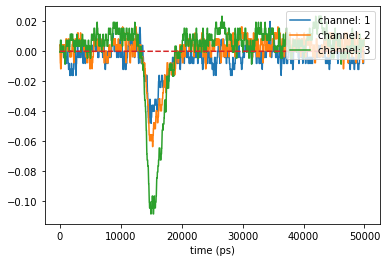

In [2]:
se1.showEvent(99,[1,2,3])

baseline: [[-0.08388335]]


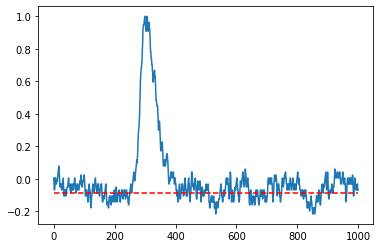

In [3]:
points = se1.getEventAdjusted(99)
bkg, data = se1.normalized_input(points[3])
base = se1.baseline_finder.predict(data.reshape(1,1000,1))
line = np.full(1000, base)
plt.plot(data)
plt.plot(line, '--',color='red')
print('baseline:',base)

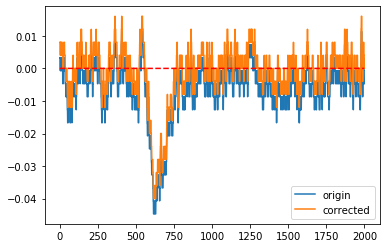

In [43]:
n=38
chan = 1
points = se1.getEventAdjusted(n)
points2 = se1.getEventAdjusted(n)
se1.cnn_baseline_correction(points,[1,2,3])
line = np.full(se1.nsamples,0)

plt.plot(points2[chan],label='origin')
plt.plot(points[chan],label='corrected')
plt.plot(line, '--',color='red')
plt.legend(loc='lower right')
plt.show()

In [32]:
charge1 = se1.charge_convertion(0,se1.nevent, 3, 0.04, [1,2],1)
charge0 = se1.charge_convertion(0,se1.nevent, 3, 0.04, [1,2],0)

In [35]:

diff=[]
diff2= []
for i in charge0[0]:
    if i not in charge1[0]: diff.append(i)
for i in charge1[0]:
    if i not in charge0[0]: diff2.append(i) 
print(len(diff))
print(len(diff2))

2
2


38


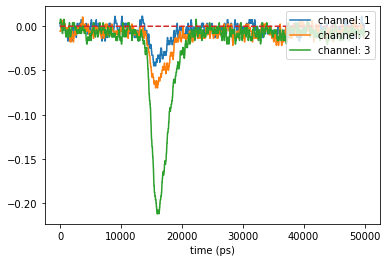

In [42]:
n=0
print(diff[n])
se1.showEvent(diff[n],[1,2,3])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
         2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  2.,  2.,
         2.,  4.,  3.,  5.,  6.,  8., 15., 25., 18., 20., 18.,  8.,  4.,
         1.]),
 array([-4019.8825   , -3918.7025625, -3817.522625 , -3716.3426875,
        -3615.16275  , -3513.9828125, -3412.802875 , -3311.6229375,
        -3210.443    , -3109.2630625, -3008.083125 , -2906.9031875,
        -2805.72325  , -2704.5433125, -2603.363375 , -2502.1834375,
        -2401.0035   , -2299.8235625, -2198.643625 , -2097.4636875,
        -1996.28375  , -1895.1038125, -1793.923875 , -1692.7439375,
        -1591.564    , -1490.3840625, -1389.204125 , -1288.0241875,
        -1186.84425  , -1085.6643125,  -984.484375 ,  -883.3044375,
         -782.1245   ,  -680.9445625,  -579.764625 ,  -478.5846875,
         -377.40475  ,  -276.2248125,  -175.044875 ,   -73.8649375,
           27.315    ]),
 <a list of 40 Patch objects>)

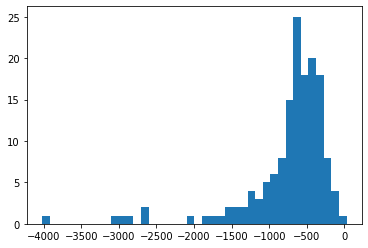

In [48]:
plt.hist(charge0[1],bins=40)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         3.,  1.,  1.,  3.,  2.,  3.,  4.,  5., 10., 12., 16., 27., 47.,
         9.]),
 array([-4407.25634715, -4304.73596356, -4202.21557997, -4099.69519638,
        -3997.17481279, -3894.6544292 , -3792.13404561, -3689.61366201,
        -3587.09327842, -3484.57289483, -3382.05251124, -3279.53212765,
        -3177.01174406, -3074.49136047, -2971.97097687, -2869.45059328,
        -2766.93020969, -2664.4098261 , -2561.88944251, -2459.36905892,
        -2356.84867533, -2254.32829174, -2151.80790814, -2049.28752455,
        -1946.76714096, -1844.24675737, -1741.72637378, -1639.20599019,
        -1536.6856066 , -1434.165223  , -1331.64483941, -1229.12445582,
        -1126.60407223, -1024.08368864,  -921.56330505,  -819.04292146,
         -716.52253786,  -614.00215427,  -511.48177068,  -408.96138709,
         -306.4410035 ]),
 <a list of 40 Patch

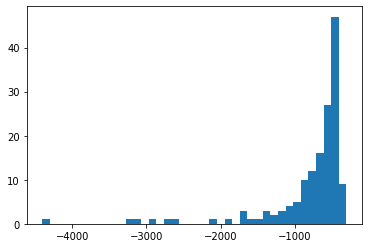

In [47]:
plt.hist(charge1[1],bins=40)

In [ ]:
se1.nevent